In [1]:
# %matplotlib inline
# najczesciej dla ulatwienia robi sie import pyplot 
import matplotlib.pyplot as plt
from lightkurve import KeplerTargetPixelFile
import numpy as np
import math
from scipy.ndimage import label
from photutils import aperture_photometry
#import scipy
import scipy.ndimage as ndimage
#import scipy.ndimage.filters as filters
from astropy.stats.funcs import median_absolute_deviation as MAD
from skimage.transform import resize
from photutils import DAOStarFinder
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
import os
from scipy.misc import imresize

from scipy import signal
from photutils import find_peaks


In [2]:
 def create_threshold_mask(image, threshold=3, reference_pixel=[10, 10]):

        if len(image.shape) > 2:
            median_image = np.nanmedian(image, axis=0)
        else:
            median_image = image
        vals = median_image[np.isfinite(median_image)].flatten()
        # Calculate the theshold value in flux units
        mad_cut = (1.4826 * MAD(vals) * threshold) + np.nanmedian(median_image)
        # Create a mask containing the pixels above the threshold flux
        threshold_mask = np.nan_to_num(median_image) > mad_cut
        if reference_pixel:
            # return all regions above threshold
            return threshold_mask
        else:
            # Return only the contiguous region closest to `region`.
            # First, label all the regions:
            labels = label(threshold_mask)[0]
            # For all pixels above threshold, compute distance to reference pixel:
            label_args = np.argwhere(labels > 0)
            distances = [np.hypot(crd[0], crd[1])
                         for crd in label_args - np.array([reference_pixel[1], reference_pixel[0]])]
            # Which label corresponds to the closest pixel?
            closest_arg = label_args[np.argmin(distances)]
            closest_label = labels[closest_arg[0], closest_arg[1]]
            return labels == closest_label

In [3]:
file_path = "./b2_lpd.fits"

pixelfile = KeplerTargetPixelFile(file_path)
fluxes = pixelfile.flux / pixelfile.flux.max()

bjd_0 = 2454833. 
bjd = pixelfile.astropy_time.value

In [4]:
anti_aliasing = False
mode = 'bilinear'

/home/pi/anaconda3/envs/astroconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


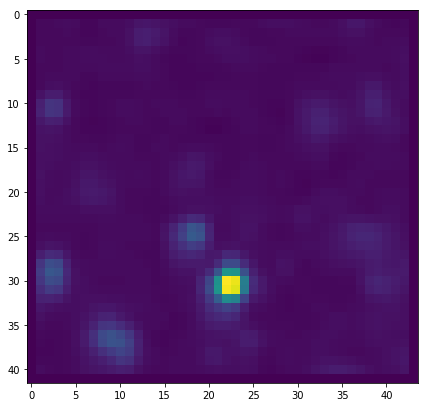

In [5]:
ref_im_num = 0
res_size = 2
th = 1

# ref_im = imresize(fluxes[ref_im_num], (fluxes[ref_im_num].shape[0]*res_size,
#                                        fluxes[ref_im_num].shape[1]*res_size), interp=mode)
ref_im = resize(fluxes[ref_im_num], (fluxes[ref_im_num].shape[0]*res_size,
                                       fluxes[ref_im_num].shape[1]*res_size),
                anti_aliasing=anti_aliasing)

ref_th = create_threshold_mask(ref_im, th)*1
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(ref_im)

In [6]:
fwhm=3.0
threshold=2.

daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*ref_im.std())    
sources = daofind(ref_im - ref_im.mean()) 

In [7]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,18.196964396487317,24.74495569142036,0.46067819716594893,-0.460442950684506,0.04367575604973911,25,0.0,0.0012649602243612326,1.5000186503392121,-0.4402416471209557
2,2.3274038258763454,29.111323561364422,0.3988093776862855,0.4929840307796134,0.6706664340499773,25,0.0,0.0012132418154208674,1.5768982989688365,-0.49450921172918944
3,22.466709976586007,30.535675536429498,0.48293827245181,0.23478950947023966,0.0727461821284962,25,0.0,0.005042886051668854,5.761908748580783,-1.9014159401796071


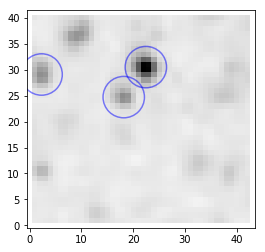

In [8]:
ap_r = 4.

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_r)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(ref_im, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [9]:
ref_aperture_num = 2

ref_position = (sources['xcentroid'][ref_aperture_num],
                sources['ycentroid'][ref_aperture_num])


In [10]:
cor = signal.correlate2d(ref_im, ref_im)
ref_center = np.unravel_index(cor.argmax(), cor.shape)

In [11]:
ref_center

(41, 43)

In [16]:
plot = False
save_file = True
save_plot = False

save_file_output_path = './output'
save_file_prefix = 'ap4'
save_file_ext = 'csv'
dist_limit = 7


phot_tab = []
bkg_tab = []
phot_bkg_tab = []
pos_tab = []
bjd_tab = []
flag_tab = []
ims = []
_range = slice(0, len(fluxes))

In [17]:
for i, frame in enumerate(zip(fluxes[_range], bjd[_range])):
    
    im, bjd_value = frame
    im = resize(im, (im.shape[0]*res_size,
                     im.shape[1]*res_size), anti_aliasing=anti_aliasing)
#     im = imresize(im, (im.shape[0]*res_size,
#                        im.shape[1]*res_size), interp=mode)
    im_th = create_threshold_mask(im, threshold=th)*1
    
    bkg_im = im * ~im_th.astype(bool)
    mean_bkg = np.nanmedian(bkg_im)
    
#     cor = signal.correlate2d(ref_th, im_th)
    cor = signal.correlate2d(ref_im - ref_im.mean(), im - im.mean())

    center = np.unravel_index(cor.argmax(), cor.shape)
    diff_center = (ref_center[0] - center[0], ref_center[1] - center[1])
    new_position = (ref_position[0] + diff_center[0], ref_position[1] + diff_center[1])
    
    aperture = CircularAperture(new_position, r=ap_r+3)
#     phot_table = aperture_photometry(im, aperture)
    
    mask_im = im.copy()
    mask_im[aperture.bounding_boxes[0].slices] = False
    mask_im[mask_im != False] = True
    mask_im = ~mask_im.astype(bool)
    
    tbl = find_peaks((im * mask_im.astype(int))*255 , 2, box_size=3)
    
    
    phot_value = 0
    bkg_value = 0
    phot_bkg_value = 0
    bjd_value = bjd_value - bjd_0
    flag = 0
    
    try:
        tbl.sort('peak_value')
        prec_center = (tbl['x_peak'][-1], tbl['y_peak'][-1])
        aperture = CircularAperture(prec_center, r=ap_r)
        phot_table = aperture_photometry(im, aperture)
        
        if np.sqrt(diff_center[0]**2 + diff_center[1]**2) > dist_limit:
            raise ZeroDivisionError
            
    except ZeroDivisionError:
        print('Distance Error')
        flag = 1
    except (KeyError, TypeError) as e:
        print('Peak Error')
        flag = 2
    else:
        phot_value = phot_table[0]['aperture_sum']
        bkg_value = aperture.area() * mean_bkg
        phot_bkg_value = phot_table[0]['aperture_sum'] - aperture.area() * mean_bkg
    finally:
        phot_tab.append(phot_value)
        bkg_tab.append(bkg_value)
        phot_bkg_tab.append(phot_bkg_value)
        pos_tab.append(diff_center)
        bjd_tab.append(bjd_value)
        flag_tab.append(flag)
        print(i, center, new_position, prec_center)
        
    if plot:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 7))
        ax1.imshow(im)
        aperture.plot(ax=ax1)
        ax2.imshow(im_th)
        ax3.imshow(mask_im)
#         plt.show()
        
    if save_plot:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
        
        ax1.set_title('i: {}'.format(i))
        ax1.imshow(im)
        aperture.plot(ax=ax1)
        
        ax2.set_title('bjd: {}'.format(bjd_value))
        ax2.imshow(im_th)
        
        ax3.set_title('flag: {}'.format(flag))
        ax3.imshow(mask_im)
        
        plt.tight_layout()
        plt.savefig(''.join(['./images/',
                             str(round(bjd_value, 2)).replace('.', '').ljust(8, '0'),
                             '.png']))
        plt.clf() 
        plt.close(f)
        
if save_file:
    save_file = '.'.join(['output', save_file_prefix,
                          os.path.basename(file_path), save_file_ext])
    header = ','.join(['bjd', 'phot_diff', 'phot', 'bkg', 'flag'])
    fmt = '%.10f %.10f %.10f %.10f %d'
    out_tab = np.c_[bjd_tab, phot_bkg_tab, phot_tab, bkg_tab, flag_tab]

    np.savetxt(os.path.join(save_file_output_path, save_file),
               out_tab, delimiter=',', fmt=fmt, header=header)
        

0 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
3 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
4 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
5 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
6 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
7 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
8 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
9 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
10 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
11 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
12 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
13 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
14 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
15 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
16 (41, 43) (22.46

138 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
139 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
140 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
141 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
142 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
143 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
144 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
145 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
146 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
147 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
148 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
149 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
150 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
151 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
152 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
153 (42, 44) (21.466709976586007, 29.535675536429498) (

271 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
272 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
273 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
274 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
275 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
276 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
277 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
278 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
279 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
280 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
281 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
282 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
283 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
284 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
285 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
286 (41, 43) (22.466709976586007, 30.535675536429498) (

404 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
405 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
406 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
407 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
408 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
409 (41, 41) (22.466709976586007, 32.535675536429494) (24, 30)
410 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
411 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
412 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
413 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
414 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
415 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
416 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
417 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
418 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
419 (41, 43) (22.466709976586007, 30.535675536429498) (

538 (41, 48) (22.466709976586007, 25.535675536429498) (17, 30)
539 (41, 48) (22.466709976586007, 25.535675536429498) (17, 30)
540 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
541 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
542 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
543 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
544 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
545 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
546 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
547 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
548 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
549 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
550 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
551 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
552 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
553 (41, 49) (22.466709976586007, 24.535675536429498) (

Distance Error
657 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
658 (35, 33) (28.466709976586007, 40.535675536429494) (32, 37)
Distance Error
659 (35, 33) (28.466709976586007, 40.535675536429494) (32, 37)
Distance Error
660 (35, 33) (28.466709976586007, 40.535675536429494) (32, 37)
Distance Error
661 (35, 33) (28.466709976586007, 40.535675536429494) (32, 37)
Distance Error
662 (35, 33) (28.466709976586007, 40.535675536429494) (32, 37)
663 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
664 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
665 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
666 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
667 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
668 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
669 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
670 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
671 (41, 43) (22.46670997658

789 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
790 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
791 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
792 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
793 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
794 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
795 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
796 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
797 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
798 (42, 44) (21.466709976586007, 29.535675536429498) (22, 30)
799 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
800 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
801 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
802 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
803 (42, 44) (21.466709976586007, 29.535675536429498) (22, 30)
804 (42, 44) (21.466709976586007, 29.535675536429498) (

922 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
923 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
924 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
925 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
926 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
927 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
928 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
929 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
930 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
931 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
932 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
933 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
934 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
935 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
936 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
937 (42, 45) (21.466709976586007, 28.535675536429498) (

1055 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1056 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1057 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1058 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1059 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1060 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1061 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1062 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1063 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1064 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1065 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1066 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1067 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1068 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1069 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1070 (41, 43) (22.466709976586007, 30.53

1188 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
Peak Error
1189 (65, 53) (-1.5332900234139935, 20.535675536429498) (22, 30)
1190 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1191 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1192 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1193 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1194 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1195 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1196 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1197 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1198 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1199 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1200 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1201 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1202 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1203 (41, 43) (22.4667099765

1321 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1322 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1323 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1324 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1325 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1326 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1327 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1328 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1329 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1330 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1331 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1332 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1333 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1334 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1335 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1336 (41, 43) (22.466709976586007, 30.53

1454 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1455 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1456 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1457 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1458 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1459 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1460 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1461 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1462 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1463 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1464 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1465 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1466 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1467 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1468 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1469 (42, 44) (21.466709976586007, 29.53

1587 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1588 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1589 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1590 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1591 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1592 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1593 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1594 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1595 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1596 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1597 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1598 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1599 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1600 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1601 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1602 (42, 45) (21.466709976586007, 28.53

1720 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1721 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1722 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1723 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1724 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1725 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1726 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1727 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1728 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1729 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1730 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1731 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1732 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1733 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1734 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1735 (41, 44) (22.466709976586007, 29.53

1853 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1854 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1855 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1856 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1857 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1858 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1859 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1860 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1861 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1862 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1863 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1864 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1865 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1866 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1867 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1868 (42, 44) (21.466709976586007, 29.53

1986 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1987 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1988 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1989 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
1990 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1991 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1992 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1993 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1994 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1995 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1996 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1997 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1998 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1999 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2000 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2001 (41, 44) (22.466709976586007, 29.53

2119 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2120 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2121 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2122 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2123 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2124 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2125 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2126 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2127 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2128 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2129 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2130 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2131 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2132 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2133 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
2134 (42, 44) (21.466709976586007, 29.53

2252 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2253 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2254 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2255 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2256 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2257 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2258 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2259 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2260 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2261 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2262 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2263 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2264 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
2265 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
2266 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
2267 (42, 45) (21.466709976586007, 28.53

2385 (41, 45) (22.466709976586007, 28.535675536429498) (21, 30)
2386 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2387 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2388 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2389 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2390 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2391 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2392 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2393 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2394 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2395 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2396 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2397 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2398 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2399 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2400 (41, 44) (22.466709976586007, 29.53

FileNotFoundError: [Errno 2] No such file or directory: './output/output.ap4.b2_lpd.fits.csv'

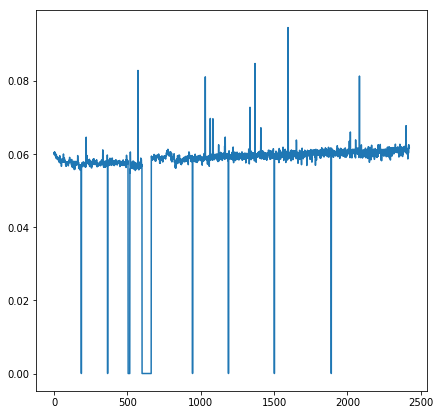

In [18]:
f, (ax1) = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(phot_bkg_tab)

plt.show()

In [19]:
aperture.area()

50.26548245743669

In [20]:
data = np.genfromtxt('./b2_blob')

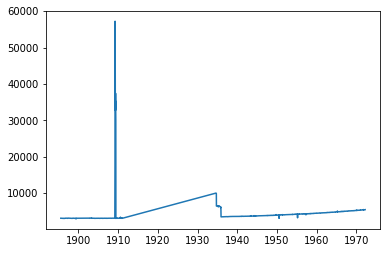

In [21]:
plt.plot(data[:,0], data[:,1])